In [46]:
from BFCalc.BFInterp import DM_spectrum_setup
from BFCalc.createspectragrids import singlechannel_diffflux, getspectrafunc
from utils import log10eaxis, logjacob, makedist, makelogjacob, bkgdist, edisp, offsetaxis, fake_signal_position_dist, inverse_transform_sampling, psf, norme_vals_mesh, normoffset_vals_mesh, setup_full_fake_signal_dist, calcirfvals
from utils import psffull, evaluateintegral, evaluateformass
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy import units as u
from scipy import special,stats
from matplotlib import cm
from tqdm.autonotebook import tqdm as notebook_tqdm
import os, sys
import functools
from multiprocessing import Pool, freeze_support
import multiprocessing
sys.path.append("BFCalc")

# Simulation 

In [3]:
offsetvals = np.linspace(-3.5,3.5,8)
logevals = np.linspace(-1,2,31)
offsetvalsmesh, logevalsmesh = np.meshgrid(offsetaxis, log10eaxis)


colormap = cm.get_cmap('coolwarm')

/var/folders/xr/793vfd394l701z7tfh27tbj9q0x4gd/T/ipykernel_62696/1171364216.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('coolwarm')


In [3]:
edispmatrix = np.empty(shape=(log10eaxis.shape[0], log10eaxis.shape[0]))

for ii, log10eval in notebook_tqdm(enumerate(log10eaxis), total=log10eaxis.shape[0]):
    edispmatrix[ii,:] = edisp(log10eaxis, log10eval, 3.5)
    
    
# psfmatrix = np.empty(shape=(offsetaxis.shape[0], offsetaxis.shape[0]))

# for ii, offsetval in notebook_tqdm(enumerate(offsetaxis), total=offsetaxis.shape[0]):
#     psfmatrix[ii,:] = psf(offsetaxis, offsetval, -0.9)



  0%|          | 0/130 [00:00<?, ?it/s]/Users/lpin0002/Desktop/DMPipe/utils.py:52: RuntimeWarning: divide by zero encountered in log
  edispfunc = lambda logerecon: np.log(edispfull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,
100%|██████████| 130/130 [00:09<00:00, 13.40it/s]


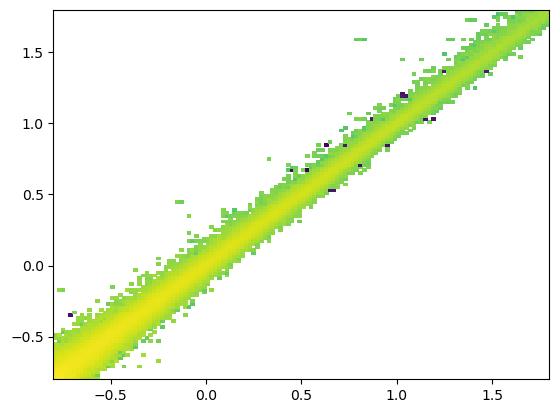

In [4]:
plt.figure()
plt.pcolor(log10eaxis, log10eaxis, edispmatrix)
plt.show()

In [5]:
# plt.figure()
# plt.pcolor(offsetaxis, offsetaxis, psfmatrix)
# plt.show()

In [25]:
log10emesh, offsetmesh = np.meshgrid(log10eaxis, offsetaxis)
Nsamples=int(1e2)
truelogmassval = 1.0

In [26]:
sigpriorvalues = []

for ii, logeval in enumerate(log10eaxis):
    singlerow = setup_full_fake_signal_dist(truelogmassval, specsetup=DM_spectrum_setup, normeaxis=10**log10eaxis)(logeval, offsetaxis)
    sigpriorvalues.append(singlerow)
    

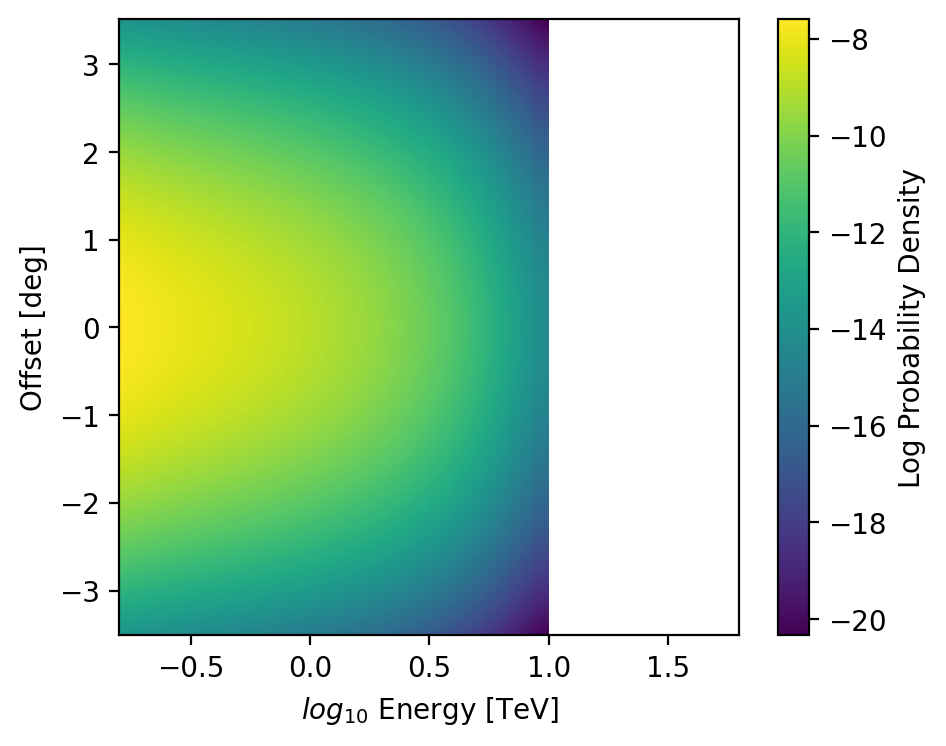

In [27]:
plt.figure(figsize=(5,4), dpi=200)
plt.pcolormesh(log10eaxis, offsetaxis, np.array(sigpriorvalues).T)
plt.xlabel(r'$log_{10}$ Energy [TeV]')
plt.ylabel('Offset [deg]')
plt.colorbar(label='Log Probability Density')

In [28]:
sigbinnedprior = np.array(sigpriorvalues)
flattened_sigbinnedprior = sigbinnedprior.flatten()

sigresultindices = np.unravel_index(inverse_transform_sampling(flattened_sigbinnedprior, Nsamples=Nsamples),sigbinnedprior.shape)
siglogevals = log10eaxis[sigresultindices[0]]
sigoffsetvals = offsetaxis[sigresultindices[1]]

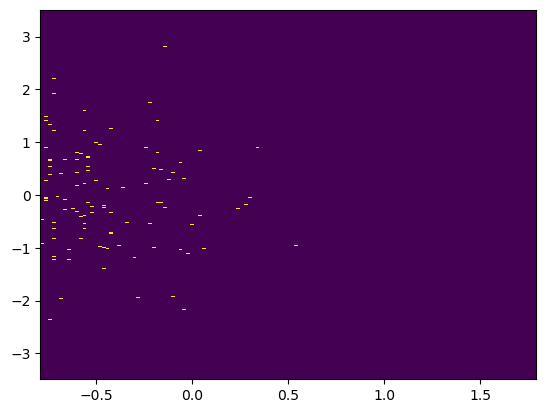

In [29]:
plt.figure()
plt.hist2d(siglogevals, sigoffsetvals, bins=[log10eaxis, offsetaxis+0.5*(offsetaxis[1]-offsetaxis[0])])
# for val in offsetaxis+0.5*(offsetaxis[1]-offsetaxis[0]):
#     plt.axhline(val, alpha=0.1, c='tab:orange')
plt.show()

In [30]:
signal_log10e_measured = log10eaxis[np.squeeze([inverse_transform_sampling(edisp(log10eaxis, logeval, offsetval)+logjacob, Nsamples=1) for logeval, offsetval in notebook_tqdm(zip(siglogevals, sigoffsetvals), total=Nsamples)])]

100%|██████████| 100/100 [00:05<00:00, 16.69it/s]


In [31]:
signal_offset_measured = offsetaxis[np.squeeze([inverse_transform_sampling(psf(offsetaxis, offsetval, logeval), Nsamples=1) for logeval, offsetval in notebook_tqdm(zip(siglogevals, sigoffsetvals), total=Nsamples)])]


100%|██████████| 100/100 [03:07<00:00,  1.87s/it]


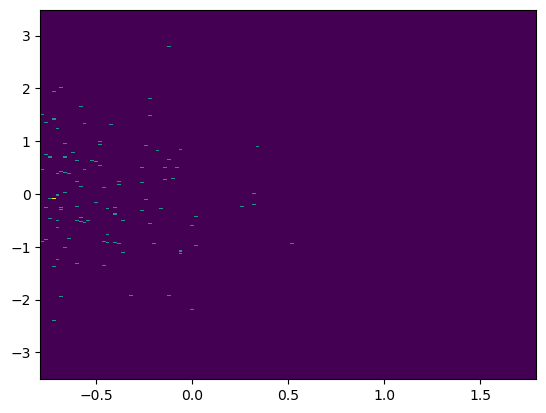

100.0

In [32]:
plt.figure()
histvals = plt.hist2d(signal_log10e_measured, signal_offset_measured, bins=[log10eaxis, offsetaxis-0.5*(offsetaxis[1]-offsetaxis[0])])
plt.show()

np.sum(histvals[0])

# Nuisance Parameter Marginalisation

In [47]:
sigdistsetup = setup_full_fake_signal_dist
# Makes it so that when np.log(0) is called a warning isn't raised as well as other errors stemming from this.
np.seterr(divide='ignore', invalid='ignore')


true_offset_vals             = np.array(list(sigoffsetvals)+list([]))
measured_offset_vals         = np.array(list(signal_offset_measured)+list([]))
true_log10e_vals             = np.array(list(siglogevals)+list([]))
measured_log10e_vals         = np.array(list(signal_log10e_measured)+list([]))

numcores                = 10
nbinslogmass            = 31
logmasswindowwidth      = 3/np.sqrt(Nsamples)
logmasslowerbound       = truelogmassval-logmasswindowwidth
logmassupperbound       = truelogmassval+logmasswindowwidth


if logmasslowerbound<log10eaxis[1]:
        logmasslowerbound = log10eaxis[1]
if logmassupperbound>2:
        logmassupperbound = 2


logmassrange         = np.linspace(logmasslowerbound,logmassupperbound,nbinslogmass)


irfvals = []
with Pool(numcores) as pool: 
        
        for result in notebook_tqdm(pool.imap(calcirfvals, zip(measured_log10e_vals, measured_offset_vals)), 
                            total=len(list(measured_log10e_vals)), ncols=100, desc="Calculating irfvals"):
                irfvals.append(result)

        pool.close() 
    

produce_posterior_function = functools.partial(evaluateformass, irfvals=irfvals, specsetup=DM_spectrum_setup)
logmass_logposterior = []
with Pool(numcores) as pool: 
        
        for result in notebook_tqdm(pool.imap(produce_posterior_function, logmassrange), total=len(list(logmassrange)), ncols=100, desc="Calculating signal marginalisations..."):
                logmass_logposterior.append(result)

        pool.close() 
    

/Users/lpin0002/Desktop/DMPipe/utils.py:52: RuntimeWarning: divide by zero encountered in log
  edispfunc = lambda logerecon: np.log(edispfull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,
/Users/lpin0002/Desktop/DMPipe/utils.py:52: RuntimeWarning: divide by zero encountered in log
  edispfunc = lambda logerecon: np.log(edispfull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,
/Users/lpin0002/Desktop/DMPipe/utils.py:52: RuntimeWarning: divide by zero encountered in log
  edispfunc = lambda logerecon: np.log(edispfull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,
/Users/lpin0002/Desktop/DMPipe/utils.py:52: RuntimeWarning: divide by zero encountered in log
  edispfunc = lambda logerecon: np.log(edispfull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,
/Users/lpin0002/Desktop/DMPipe/utils.py:52: RuntimeWarning: divide by zero encountered in log
  edispfunc = lambda logerecon: np.log(edispfull.evaluate(energy_true=np.power(10.,logetrue)*u.TeV,
/Users/lpin0002/Desktop/DMPipe

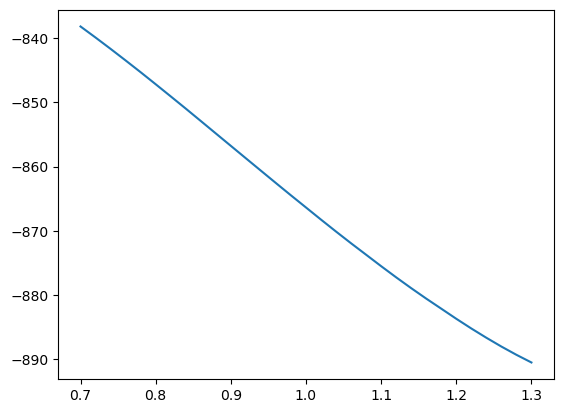

In [48]:
plt.figure()
plt.plot(logmassrange, logmass_logposterior)
plt.show()